# Stock market prediction using RNNs with TensorFlow

This notebook illustrates:

* Creating a Recurrent Neural Network in TensorFlow
* Creating a Custom Estimator in tf.estimator
* Training a deep learning model on finance data

In [1]:
%matplotlib inline
import datetime

import numpy as np
import pandas as pd
import tensorflow as tf

from matplotlib import pyplot as plt

/home/project/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Read historical stock data

Utilize `quandl` to download historical stock data for a couple of tech stocks. See appendix.

In [15]:
# Load data
df = pd.read_csv("../../../../datas/spx-1950-2018.csv")
df.Date = pd.to_datetime(df.Date)
df = df.set_index("Date")
Open_pct_change = (df.Open/df.Open.shift()-1)
Close_pct_change = (df.Close/df.Close.shift()-1)
Volume_pct_change = (df.Close/df.Close.shift()-1)
Range = (df.High - df.Low)/df.Close
df_features = pd.DataFrame([Open_pct_change,Range,Close_pct_change,Volume_pct_change],index=['Open','Range','Close','Volume']).T.dropna()

In [16]:
df_features

,Open,Range,Close,Volume
Date,,,,
1950-01-04,0.011405,0.000000,0.011405,0.011405
1950-01-05,0.004748,0.000000,0.004748,0.004748
1950-01-06,0.002953,0.000000,0.002953,0.002953
1950-01-09,0.006478,0.000585,0.005889,0.005889
1950-01-10,-0.003511,0.000000,-0.002927,-0.002927
1950-01-11,0.003523,0.000000,0.003523,0.003523
1950-01-12,-0.019310,0.000000,-0.019310,-0.019310
1950-01-13,-0.005370,0.000000,-0.005370,-0.005370
1950-01-16,-0.001200,0.004187,0.002999,0.002999


In [3]:
df_pct_change.count()

Open      17145
High      17145
Low       17145
Close     17145
Volume    17145
dtype: int64

## Create training data for RNN model

Here, we are trying to predict the close price of a stock, given the close prices from the prior days. We will utilize a look back period of `window_size`. 

For the labels, we will shift the window size one time step forward. See the image for a visualization:

![](img/rnn_viz.png)

Our data will need to be formatted as follows:

![](img/rnn_input.png)

Check out [the docs](https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn) for more info

For more info on RNNs, see:

* http://colah.github.io/posts/2015-08-Understanding-LSTMs/ for the theory
* https://www.tensorflow.org/tutorials/recurrent for explanations
* https://github.com/tensorflow/models/tree/master/tutorials/rnn/ptb for sample code

In [4]:
def _keep(window, windows):
    """Helper function for creating rolling windows"""
    windows.append(window.copy())
    return window[-1]

def create_rolling_windows(series, window_size):
    """Given input array, we want to output sliding windows. Additionally for the RNN model,
    the input will be a given window and the label will be a window shifted one time step into 
    the future:
    
    input: [5,2,6,2,7], window_size=3
    output: 
        x: [[5,2,6], [2,6,2]]
        y: [[2,6,2], [6,2,7]]
    """
    
    windows = list()
    series.rolling(window_size).apply(_keep, args=(windows,))

    Xs, ys = [], []
    x = windows[0]
    for i in range(1, len(windows)):
        y = windows[i]
        Xs.append(x)
        ys.append(y)
        x = y
    # add third dimension using broadcasting- needed for input into RNN
    # [batch_size, n_steps, n_inputs]
    Xs = np.array(Xs)[:, :, None] 
    ys = np.array(ys)[:, :, None]
    return Xs, ys

def get_close(stock):
    """Closing price is 4th column"""
    return stock.iloc[:,3]

n_steps = 15  # look back period

train_windows = create_rolling_windows(get_close(df_pct_change.iloc[:-3000]), window_size=n_steps)
test_windows = create_rolling_windows(get_close(df_pct_change.iloc[-3000:]), window_size=n_steps)

# train
train_X = train_windows[0]
train_Y = train_windows[1]

mean_X = train_X.mean()
std_X = train_X.std()
mean_Y = train_Y.mean()
std_Y = train_Y.std()

train_X = (train_X-mean_X)/std_X
train_Y = (train_Y-mean_Y)/std_Y

# test
test_X = (test_windows[0]-mean_X)/std_X
test_Y = (test_windows[1]-mean_Y)/std_Y

# Train a RNN model

In [5]:
def input_fn(x_windows, y_windows, num_epochs=None, batch_size=200, shuffle=True):
    """We need to feed the data into the model for both training and predictions"""
    feature_dict = {'stock_price': x_windows}
    return tf.estimator.inputs.numpy_input_fn(x=feature_dict, y=y_windows,
                                              num_epochs=num_epochs,
                                              batch_size=batch_size,
                                              shuffle=shuffle)

def rnn_model(features, labels, mode, params):
    """Build a custom estimator. See here for more info:
    https://www.tensorflow.org/get_started/custom_estimators
    
    The mode argument defines if we are in training, eval, or testing
    """
    # define model
    X = features['stock_price']
    cell = tf.contrib.rnn.BasicLSTMCell(num_units=params['n_neurons'])
    cell_drop = tf.contrib.rnn.DropoutWrapper(cell, input_keep_prob=0.8)
    rnn_outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float64)

    # trickery to restack all outputs of rnn
    # book source:Hands-On Machine Learning with Scikit-Learn and TensorFlow
    # alternative approach: use OutputProjectionWrapper
    stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, params['n_neurons']])
    stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
    outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs]) 
    
    # compute predictions
    next_step_prediction = outputs[:,-1,0]
    if mode == tf.estimator.ModeKeys.PREDICT:
        predictions = {
            'outputs': outputs,
            'next_step_prediction': next_step_prediction
        }
        return tf.estimator.EstimatorSpec(mode, predictions=predictions)
    
    # get performance on eval dataset
    loss = tf.losses.mean_squared_error(labels, outputs)
#     tf.summary.scalar('loss_rms', loss)  # for tensorboard
    if mode == tf.estimator.ModeKeys.EVAL:
        return tf.estimator.EstimatorSpec(mode, loss=loss)
    
    
    # now in training, so train the model
    optimizer = tf.train.AdamOptimizer(learning_rate=params['learning_rate'])
    train_op = optimizer.minimize(loss, global_step=tf.train.get_global_step())
    
    return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op)    

tf.logging.set_verbosity(tf.logging.INFO)

n_inputs = 1  # just 1 bc only using a single signal
n_outputs = 1 
N_NEURONS = 10

# 
BATCH_SIZE = 500
NUM_EPOCHS = 100
LEARNING_RATE = 0.001

num_train_examples = train_X.shape[0]
n_iterations = int(np.ceil(num_train_examples/BATCH_SIZE))*NUM_EPOCHS

OUTPUT_DIR = './stock_model'
!rm -r stock_model  # unix
# !rd /s /q stock_model  # windows

# build our estimator and train the model
regressor = tf.estimator.Estimator(model_fn=rnn_model,
                                   model_dir=OUTPUT_DIR,
                                   params={'learning_rate': LEARNING_RATE,
                                           'n_neurons': N_NEURONS})
regressor.train(input_fn(train_X, train_Y,
                         batch_size=BATCH_SIZE,
                         num_epochs=None, shuffle=True), max_steps=n_iterations)

predictions = list(regressor.predict(input_fn(test_X, test_Y, num_epochs=1, shuffle=False)))
y_pred = np.array([p['outputs'] for p in predictions])

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './stock_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f4000b56048>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into ./stock_model/model.ckpt.
INFO:tensorflow:loss = 0.34560585, step = 1
INFO:tensorflow:g

## Visualize prediction results

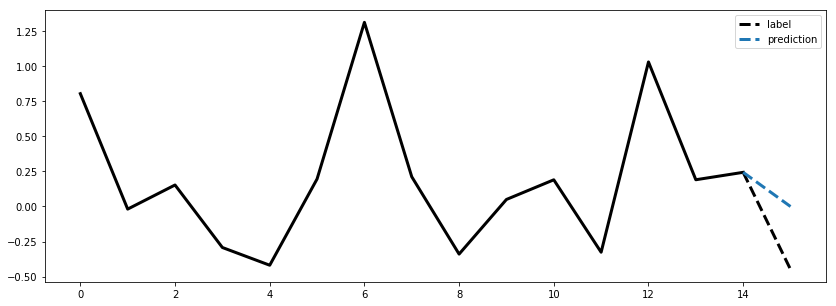

In [6]:
i = 128  # example number

x_in  = test_X[i,:,0]
y_out = test_X[i+1,:,0]
pred = y_pred[i,:,0]
time = np.arange(n_steps)


single_pred = [y_out[-2]] + [pred[-1]] 
single_pred_time = (time+1)[-2:]

plt.figure(figsize=(14,5))
plt.plot(time, x_in, linewidth=3, c='black')

plt.plot((time+1)[-2:], y_out[-2:], linestyle='dashed', label='label', linewidth=3, c='black')
plt.plot(single_pred_time, single_pred, linestyle='dashed', label='prediction', linewidth=3)
plt.legend();

## Evaluate results
The model is for demo purposes only, to show how to utilize RNNs. However, here is a potential scheme to test the results.

In [7]:
def get_tomorrow_direction(delta_val, significant_thresh=0.0001):
    stock_up = delta_val > 0
    significant_change = abs(delta_val) > significant_thresh
    if not significant_change:
        return 'stay'
    elif stock_up:
        return 'up'
    else:
        return 'down'

models = {'always_stay': [],
          'always_up': [],
          'always_down': [],
          'rnn': []}
for i in range(499):
    x  = test_X[i,:,0]
    y = test_Y[i,:,0] 
    pred  = y_pred[i,:,0]   
    current = x[-1]
    tomorrow_label = y[-1]
    tomorrow_predicted = pred[-1]

    delta_label = (tomorrow_label - current)/(current+1e-7)
    delta_pred  = (tomorrow_predicted - current)/(current+1e-7)

    direction_label = get_tomorrow_direction(delta_label)
    direction_predicted = get_tomorrow_direction(delta_pred)
    correct_pick = direction_predicted == direction_label
    models['rnn'].append(correct_pick)
    for pick, model in zip(('up','down','stay'),
                           ('always_up', 'always_down', 'always_stay')):
        models[model].append(pick==direction_label)
pd.DataFrame(models).mean()

always_down    0.779559
always_stay    0.000000
always_up      0.220441
rnn            0.775551
dtype: float64


Copyright 2018 Google Inc. All Rights Reserved. you may not use this file except in compliance with the License. You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.